In [1]:
# checking for tensorflow devices
from tensorflow.python.client import device_lib
for d in device_lib.list_local_devices():
    print(d.name, d.physical_device_desc)

/device:CPU:0 
/device:GPU:0 device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1b.0, compute capability: 7.0
/device:GPU:1 device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1c.0, compute capability: 7.0
/device:GPU:2 device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1d.0, compute capability: 7.0
/device:GPU:3 device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0


In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import optimizers
import keras.backend as K
from keras.utils import to_categorical, multi_gpu_model
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from sklearn.datasets import load_iris
from keras.datasets import fashion_mnist, mnist, cifar100
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.applications.resnet50 import ResNet50, decode_predictions
import cv2
from tqdm import tqdm

np.set_printoptions(suppress=True)
%matplotlib inline

Using TensorFlow backend.


In [3]:
df_train = pd.read_csv('kaggle/planet-understanding-the-amazon-from-space/data/train.csv')
df_train.head(3)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary


In [4]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
labels

['clear',
 'artisinal_mine',
 'selective_logging',
 'agriculture',
 'cloudy',
 'primary',
 'road',
 'blooming',
 'bare_ground',
 'cultivation',
 'haze',
 'water',
 'blow_down',
 'conventional_mine',
 'partly_cloudy',
 'habitation',
 'slash_burn']

In [5]:
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [6]:
label_map

{'clear': 0,
 'artisinal_mine': 1,
 'selective_logging': 2,
 'agriculture': 3,
 'cloudy': 4,
 'primary': 5,
 'road': 6,
 'blooming': 7,
 'bare_ground': 8,
 'cultivation': 9,
 'haze': 10,
 'water': 11,
 'blow_down': 12,
 'conventional_mine': 13,
 'partly_cloudy': 14,
 'habitation': 15,
 'slash_burn': 16}

In [7]:
inv_label_map

{0: 'clear',
 1: 'artisinal_mine',
 2: 'selective_logging',
 3: 'agriculture',
 4: 'cloudy',
 5: 'primary',
 6: 'road',
 7: 'blooming',
 8: 'bare_ground',
 9: 'cultivation',
 10: 'haze',
 11: 'water',
 12: 'blow_down',
 13: 'conventional_mine',
 14: 'partly_cloudy',
 15: 'habitation',
 16: 'slash_burn'}

In [8]:
x_train = []
y_train = []

In [9]:
for f, tags in tqdm(df_train.values, miniters=1000):
    path = 'kaggle/planet-understanding-the-amazon-from-space/data/train/satellite/{}.jpg'.format(f)
    img = cv2.imread(path)
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (256, 256)))
    y_train.append(targets)

100%|██████████| 40479/40479 [00:51<00:00, 781.04it/s]


In [10]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [11]:
x_train[0].shape

(256, 256, 3)

In [12]:
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float64) / 255.

In [13]:
y_train[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [14]:
x_train[0].shape

(256, 256, 3)

In [15]:
split = 35000
x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

In [16]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((35000, 256, 256, 3), (5479, 256, 256, 3), (35000, 17), (5479, 17))

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 128)       0         
__________

In [21]:
parallel_model = multi_gpu_model(model, 4)
parallel_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
parallel_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_4_input (InputLayer)     (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 3)  0           conv2d_4_input[0][0]             
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 256, 256, 3)  0           conv2d_4_input[0][0]             
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 256, 256, 3)  0           conv2d_4_input[0][0]             
__________________________________________________________________________________________________
lambda_8 (

In [22]:
history = parallel_model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(x_valid, y_valid))

Train on 35000 samples, validate on 5479 samples
Epoch 1/20
35000/35000 [==============================] - 48s 1ms/step - loss: 0.2546 - acc: 0.9038 - val_loss: 0.2046 - val_acc: 0.9173
Epoch 2/20
35000/35000 [==============================] - 44s 1ms/step - loss: 0.2095 - acc: 0.9185 - val_loss: 0.1886 - val_acc: 0.9241
Epoch 3/20
35000/35000 [==============================] - 43s 1ms/step - loss: 0.1950 - acc: 0.9232 - val_loss: 0.1757 - val_acc: 0.9293
Epoch 4/20
35000/35000 [==============================] - 43s 1ms/step - loss: 0.1871 - acc: 0.9268 - val_loss: 0.1711 - val_acc: 0.9315
Epoch 5/20
35000/35000 [==============================] - 44s 1ms/step - loss: 0.1778 - acc: 0.9305 - val_loss: 0.1731 - val_acc: 0.9315
Epoch 6/20
35000/35000 [==============================] - 44s 1ms/step - loss: 0.1708 - acc: 0.9331 - val_loss: 0.1651 - val_acc: 0.9358
Epoch 7/20
35000/35000 [==============================] - 43s 1ms/step - loss: 0.1657 - acc: 0.9353 - val_loss: 0.1551 - val_acc:

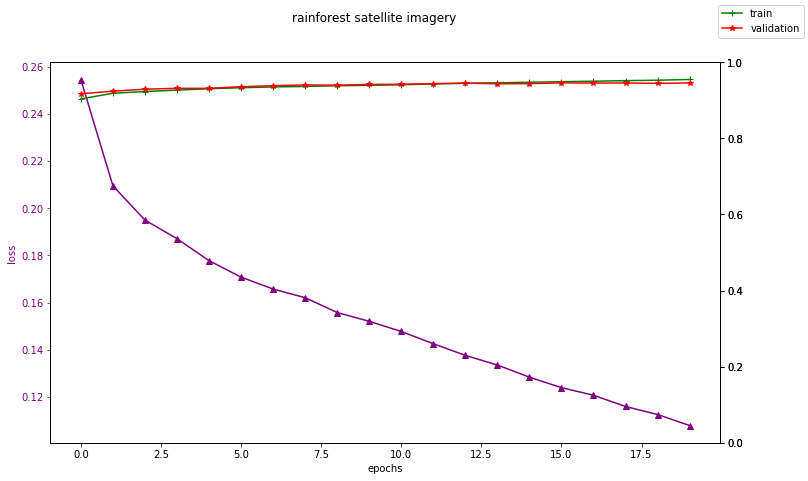

In [23]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(history.epoch, history.history['loss'], marker='^', color='purple')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')

ax2 = ax1.twinx()
plt.plot(history.epoch, history.history['acc'], marker='+', color='green', label='train')
ax2.set_ylim(0,1)

ax3 = ax1.twinx()
plt.plot(history.epoch, history.history['val_acc'], marker='*', color='red', label='validation')
ax3.set_ylim(0,1)

fig.suptitle('rainforest satellite imagery');
fig.legend();

[(0.99982893, 'clear'), (0.75815636, 'agriculture'), (0.99999547, 'primary')]
[(1, 'primary'), (1, 'cultivation'), (1, 'haze'), (1, 'slash_burn')]


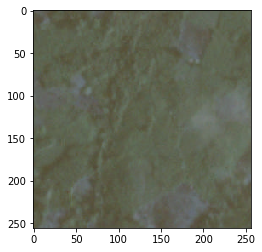

[(0.999877, 'clear'), (0.9303916, 'agriculture'), (0.9999151, 'primary'), (0.6120964, 'road')]
[(1, 'clear'), (1, 'agriculture'), (1, 'primary'), (1, 'road')]


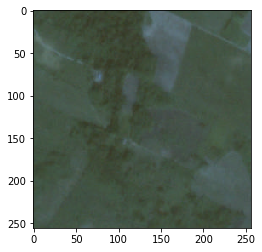

[(1.0, 'clear'), (0.90402347, 'agriculture'), (1.0, 'primary'), (0.6447628, 'water')]
[(1, 'clear'), (1, 'agriculture'), (1, 'primary'), (1, 'cultivation'), (1, 'water')]


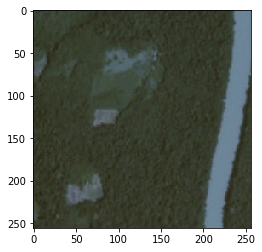

[(1.0, 'clear'), (1.0, 'primary'), (0.68683654, 'water')]
[(1, 'clear'), (1, 'selective_logging'), (1, 'primary'), (1, 'road')]


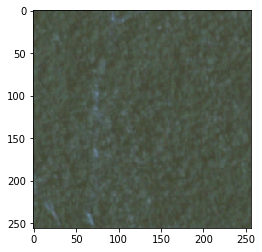

[(0.9998449, 'clear'), (1.0, 'primary')]
[(1, 'clear'), (1, 'primary')]


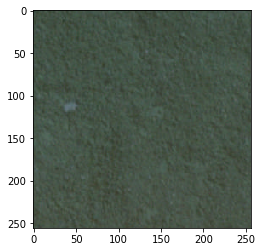

[(0.9999999, 'clear'), (1.0, 'primary')]
[(1, 'clear'), (1, 'primary')]


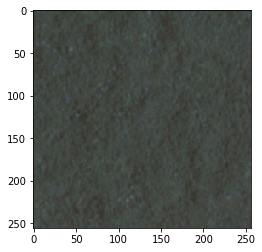

[(0.6717195, 'agriculture'), (0.99995947, 'primary'), (0.6557003, 'water'), (0.9239234, 'partly_cloudy')]
[(1, 'primary'), (1, 'water'), (1, 'partly_cloudy')]


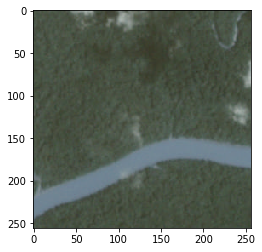

[(0.99997544, 'primary'), (0.98487675, 'partly_cloudy')]
[(1, 'primary'), (1, 'partly_cloudy')]


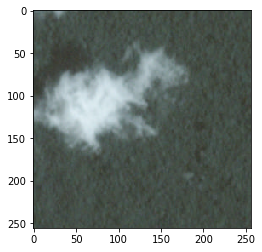

[(0.9953862, 'primary'), (0.8144985, 'partly_cloudy')]
[(1, 'primary'), (1, 'partly_cloudy')]


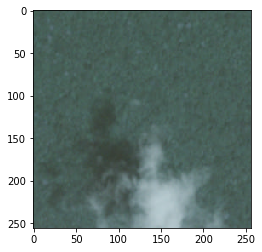

[(0.6237, 'clear'), (0.88293535, 'agriculture'), (0.866153, 'primary'), (0.8473571, 'road')]
[(1, 'agriculture'), (1, 'primary'), (1, 'road'), (1, 'cultivation'), (1, 'partly_cloudy'), (1, 'habitation')]


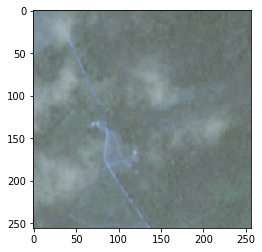

In [54]:
for i in range(10):
    p_results = [(p,labels[i]) for i, p in  enumerate(parallel_model.predict(np.array([x_valid[i]]))[0]) if p > 0.5]
    t_results = [(p,labels[i]) for i, p in enumerate(y_valid[i]) if p == 1]
    print(p_results)
    print(t_results)
    plt.imshow(x_valid[i])
    plt.show()